# 1. Introduction

In this notebook we try a deep learning approach (Sequence to Sequence model or Seq2seq) to predict the future sales. The seq2seq model uses recurrent neural network to predict a series based on another series. Both the input and output series can be multi-dimensional. In our model, we use the daily sales series in the past 242 days, together with the RFM features in the past period, to predict the monthly sales in the next three months. 

There are other ways to design the model as well. For example, we can predict the daily sales series in the next 90 days. However, after several trials, I found other ways not very efficient so we will for now stick with this design. I wanted to include the customer features at the beginning. But adding those features won't help much and the algorithm may not work well with those features. So in the end I only included the RFM features (calculated for the corresponding calibration period) (also recall that in the boosting tree model we found the RFM features the most important). The pre-processing of the RFM features is the same as we did for the boosting tree model.

Below is a graph showing how we will configure the predictors and target variables:

<img src="seq.png">

I'm very new to this model and most of the codes below were borrowed from 
<br>https://github.com/farizrahman4u/seq2seq/blob/master/tests/test.py
<br>https://github.com/farizrahman4u/recurrentshop/tree/master/recurrentshop

Since I'm only using the very simple kind of seq2seq model and we only have 20000 samples here, the prediction result might have very low accuracy. However, it's still worth a try. 

# 2. Helper functions

In [1]:
from keras.models import Model
from keras.layers import *

Using TensorFlow backend.
/home/ubuntu/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [2]:
from __future__ import absolute_import
from recurrentshop import *

In [3]:
class RNNCell(Layer):

    def __init__(self, output_dim=None, **kwargs):
        if 'input_shape' not in kwargs and 'input_dim' in kwargs:
            kwargs['input_shape'] = (kwargs.pop('input_dim'),)
        self.output_dim = output_dim
        if 'batch_input_shape' in kwargs:
            self.model = self.build_model(kwargs['batch_input_shape'])
        elif 'input_shape' in kwargs:
            self.model = self.build_model((None,) + kwargs['input_shape'])
        if not hasattr(self, 'input_ndim'):
            self.input_ndim = 2
        super(RNNCell, self).__init__(**kwargs)

    def build(self, input_shape):
        if type(input_shape) is list:
            self.input_spec = [InputSpec(shape=shape) for shape in input_shape]
            self.model = self.build_model(input_shape[0])
        else:
            self.model = self.build_model(input_shape)
            self.input_spec = [InputSpec(shape=shape) for shape in _to_list(self.model.input_shape)]

    def build_model(self, input_shape):
        raise Exception(NotImplemented)

    @property
    def num_states(self):
        if hasattr(self, 'model'):
            model = self.model
        else:
            model = self.build_model((None,) + (2,) * (self.input_ndim - 1))  # Don't judge. It was 3 in the morning.
        model_input = model.input
        if type(model_input) is list:
            return len(model_input[1:])
        else:
            return 0

    @property
    def state_shape(self):
        model_input = self.model.input
        if type(model_input) is list:
            if len(model_input) == 2:
                return K.int_shape(model_input[1])
            else:
                return list(map(K.int_shape, model_input[1:]))
        else:
            return None

    def compute_output_shape(self, input_shape):
        model_inputs = self.model.input
        if type(model_inputs) is list and type(input_shape) is not list:
            input_shape = [input_shape] + list(map(K.int_shape, self.model.input[1:]))
        return self.model.compute_output_shape(input_shape)

    def call(self, inputs, learning=None):
        return self.model.call(inputs)

    def get_layer(self, **kwargs):
        input_shape = self.model.input_shape
        if type(input_shape) is list:
            state_shapes = input_shape[1:]
            input_shape = input_shape[0]
        else:
            state_shapes = []
        input = Input(batch_shape=input_shape)
        initial_states = [Input(batch_shape=shape) for shape in state_shapes]
        output = self.model([input] + initial_states)
        if type(output) is list:
            final_states = output[1:]
            output = output[0]
        else:
            final_states = []
        return RecurrentModel(input=input, output=output, initial_states=initial_states, final_states=final_states, **kwargs)

    @property
    def updates(self):
        return self.model.updates

    def add_update(self, updates, inputs=None):
        self.model.add_update(updates, inputs)

    @property
    def uses_learning_phase(self):
        return self.model.uses_learning_phase

    @property
    def _per_input_losses(self):
        if hasattr(self, 'model'):
            return getattr(self.model, '_per_input_losses', {})
        else:
            return {}

    @_per_input_losses.setter
    def _per_input_losses(self, val):
        if hasattr(self, 'model'):
            self.model._per_input_losses = val

    @property
    def losses(self):
        if hasattr(self, 'model'):
            return self.model.losses
        else:
            return []

    @losses.setter
    def losses(self, val):
        if hasattr(self, 'model'):
            self.model.losses = val

    def add_loss(self, losses, inputs=None):
        self.model.add_loss(losses, inputs)

    @property
    def constraints(self):
        return self.model.constraints

    @property
    def trainable_weights(self):
        return self.model.trainable_weights

    @property
    def non_trainable_weights(self):
        return self.model.non_trainable_weights

    def get_losses_for(self, inputs):
        return self.model.get_losses_for(inputs)

    def get_updates_for(self, inputs):
        return self.model.get_updates_for(inputs)

    def set_weights(self, weights):
        self.model.set_weights(weights)

    def get_weights(self):
        return self.model.get_weights()

    def get_config(self):
        config = {'output_dim': self.output_dim}
        base_config = super(RNNCell, self).get_config()
        config.update(base_config)
        return config

    def compute_mask(self, inputs, mask=None):
        model_output = self.model.output
        if type(model_output) is list:
            return [None] * len(model_output)
        else:
            return None

In [4]:
def _to_list(x):
    if type(x) is not list:
        x = [x]
    return x

def _is_rnn_cell(cell):
    return issubclass(cell.__class__, RNNCell)


def _is_all_none(iterable_or_element):
    if not isinstance(iterable_or_element, (list, tuple)):
        iterable = [iterable_or_element]
    else:
        iterable = iterable_or_element
    for element in iterable:
        if element is not None:
            return False
    return True

def _get_cell_input_shape(cell):
    if hasattr(cell, 'batch_input_shape'):
        cell_input_shape = cell.batch_input_shape
    elif hasattr(cell, 'input_shape'):
        cell_input_shape = cell.input_shape
    elif hasattr(cell, 'input_spec'):
        if isinstance(cell.input_spec, list):
            if hasattr(cell.input_spec[0], 'shape'):
                cell_input_shape = cell.input_spec[0].shape
            else:
                cell_input_shape = None
        else:
            if hasattr(cell.input_spec, 'shape'):
                cell_input_shape = cell.input_spec.shape
            else:
                cell_input_shape = None
    else:
        cell_input_shape = None

    if cell_input_shape is not None:
        if set(map(type, list(set(cell_input_shape) - set([None])))) != set([int]):
            cell_input_shape = cell_input_shape[0]

    return cell_input_shape

In [5]:
class RecurrentSequential(RecurrentModel):

    def __init__(self, state_sync=False, decode=False, output_length=None, return_states=False, readout=False, readout_activation='linear', teacher_force=False, state_initializer=None, **kwargs):
        self.state_sync = state_sync
        self.cells = []
        if decode and output_length is None:
            raise Exception('output_length should be specified for decoder')
        self.decode = decode
        self.output_length = output_length
        if decode:
            if output_length is None:
                raise Exception('output_length should be specified for decoder')
            kwargs['return_sequences'] = True
        self.return_states = return_states
        super(RecurrentModel, self).__init__(**kwargs)
        self.readout = readout
        self.readout_activation = activations.get(readout_activation)
        self.teacher_force = teacher_force
        self._optional_input_placeholders = {}
        if state_initializer:
            if type(state_initializer) in [list, tuple]:
                state_initializer = [initializers.get(init) if init else initializers.get('zeros') for init in state_initializer]
            else:
                state_initializer = initializers.get(state_initializer)
        self._state_initializer = state_initializer

    @property
    def state_initializer(self):
        if self._state_initializer is None:
            return None
        elif type(self._state_initializer) is list:
            return self._state_initializer + [initializers.get('zeros')] * (self.num_states - len(self._state_initializer))
        else:
            return [self._state_initializer] * self.num_states

    @state_initializer.setter
    def state_initializer(self, value):
        self._state_initializer = value

    @property
    def num_states(self):
        if hasattr(self, 'model'):
            return super(RecurrentSequential, self).num_states
        num = 0
        for cell in self.cells:
            if _is_rnn_cell(cell):
                num += cell.num_states
                if self.state_sync:
                    break
        if self.readout:
            num += 1
        return num

    def add(self, cell):
        self.cells.append(cell)
        cell_input_shape = _get_cell_input_shape(cell)
        if len(self.cells) == 1:
            if len(self.cells) == 1:
                if self.decode:
                    self.input_spec = InputSpec(shape=cell_input_shape)
                else:
                    self.input_spec = InputSpec(shape=cell_input_shape[:1] + (None,) + cell_input_shape[1:])

        if cell_input_shape is not None:
            cell_input_shape = cell.batch_input_shape
            batch_size = cell_input_shape[0]
            if batch_size is not None:
                self.batch_size = batch_size
            if not self.stateful:
                self.states = [None] * self.num_states

    def build(self, input_shape):
        if hasattr(self, 'model'):
            del self.model
        # Try and get batch size for initializer
        if not hasattr(self, 'batch_size'):
            if hasattr(self, 'batch_input_shape'):
                batch_size = self.batch_input_shape[0]
                if batch_size is not None:
                    self.batch_size = batch_size
        if self.state_sync:
            if type(input_shape) is list:
                x_shape = input_shape[0]
                if not self.decode:
                    input_length = x_shape.pop(1)
                    if input_length is not None:
                        shape = list(self.input_spec.shape)
                        shape[1] = input_length
                        self.input_spec = InputSpec(shape=tuple(shape))
                input = Input(batch_shape=x_shape)
                initial_states = [Input(batch_shape=shape) for shape in input_shape[1:]]
            else:
                if not self.decode:
                    input_length = input_shape[1]
                    if input_length is not None:
                        shape = list(self.input_spec.shape)
                        shape[1] = input_length
                        self.input_spec = InputSpec(shape=tuple(shape))
                    input = Input(batch_shape=input_shape[:1] + input_shape[2:])
                else:
                    input = Input(batch_shape=input_shape)
                initial_states = []
            output = input
            final_states = initial_states[:]
            for cell in self.cells:
                if _is_rnn_cell(cell):
                    if not initial_states:
                        cell.build(K.int_shape(output))
                        initial_states = [Input(batch_shape=shape) for shape in _to_list(cell.state_shape)]
                        final_states = initial_states[:]
                    cell_out = cell([output] + final_states)
                    if type(cell_out) is not list:
                        cell_out = [cell_out]
                    output = cell_out[0]
                    final_states = cell_out[1:]
                else:
                    output = cell(output)
        else:
            if type(input_shape) is list:
                x_shape = input_shape[0]
                if not self.decode:
                    input_length = x_shape.pop(1)
                    if input_length is not None:
                        shape = list(self.input_spec.shape)
                        shape[1] = input_length
                        self.input_spec = InputSpec(shape=tuple(shape))
                input = Input(batch_shape=x_shape)
                initial_states = [Input(batch_shape=shape) for shape in input_shape[1:]]
                output = input
                final_states = []
                for cell in self.cells:
                    if _is_rnn_cell(cell):
                        cell_initial_states = initial_states[len(final_states): len(final_states) + cell.num_states]
                        cell_in = [output] + cell_initial_states
                        cell_out = _to_list(cell(cell_in))
                        output = cell_out[0]
                        final_states += cell_out[1:]
                    else:
                        output = cell(output)
            else:
                if not self.decode:
                    input_length = input_shape[1]
                    if input_length is not None:
                        shape = list(self.input_spec.shape)
                        shape[1] = input_length
                        self.input_spec = InputSpec(shape=tuple(shape))
                    input = Input(batch_shape=input_shape[:1] + input_shape[2:])
                else:
                    input = Input(batch_shape=input_shape)
                output = input
                initial_states = []
                final_states = []
                for cell in self.cells:
                    if _is_rnn_cell(cell):
                        cell.build(K.int_shape(output))
                        state_inputs = [Input(batch_shape=shape) for shape in _to_list(cell.state_shape)]
                        initial_states += state_inputs
                        cell_in = [output] + state_inputs
                        cell_out = _to_list(cell(cell_in))
                        output = cell_out[0]
                        final_states += cell_out[1:]
                    else:
                        output = cell(output)

        self.model = Model([input] + initial_states, [output] + final_states)
        self.states = [None] * len(initial_states)
        if self.readout:
            readout_input = Input(batch_shape=K.int_shape(output), name='readout_input')
            if self.readout_activation.__name__ == 'linear':
                readout = Lambda(lambda x: x + 0., output_shape=lambda s: s)(readout_input)
            else:
                readout = Activation(self.readout_activation)(readout_input)
            input = Input(batch_shape=K.int_shape(input))
            if self.readout in [True, 'add']:
                input_readout_merged = add([input, readout])
            elif self.readout in ['mul', 'multiply']:
                input_readout_merged = multiply([input, readout])
            elif self.readout in ['avg', 'average']:
                input_readout_merged = average([input, readout])
            elif self.readout in ['max', 'maximum']:
                input_readout_merged = maximum([input, readout])
            elif self.readout == 'readout_only':
                input_readout_merged = readout
            initial_states = [Input(batch_shape=K.int_shape(s)) for s in initial_states]
            output = _to_list(self.model([input_readout_merged] + initial_states))
            final_states = output[1:]
            output = output[0]
            self.model = Model([input] + initial_states + [readout_input], [output] + final_states)
            self.states.append(None)
        super(RecurrentSequential, self).build(input_shape)

    def get_config(self):
        config = {'cells': list(map(serialize, self.cells)),
                  'decode': self.decode,
                  'output_length': self.output_length,
                  'readout': self.readout,
                  'teacher_force': self.teacher_force,
                  'return_states': self.return_states,
                  'state_sync': self.state_sync,
                  'state_initializer': self._serialize_state_initializer(),
                  'readout_activation': activations.serialize(self.readout_activation)}
        base_config = super(RecurrentModel, self).get_config()
        config.update(base_config)
        return config

    @classmethod
    def from_config(cls, config, custom_objects={}):
        custom_objects.update(_get_cells())
        cells = config.pop('cells')
        rs = cls(**config)
        for cell_config in cells:
            cell = deserialize(cell_config, custom_objects)
            rs.add(cell)
        return rs


# Legacy
RecurrentContainer = RecurrentSequential

In [6]:
class LSTMCell(RNNCell):

    def build_model(self, input_shape):
        output_dim = self.output_dim
        input_dim = input_shape[-1]
        output_shape = (input_shape[0], output_dim)
        x = Input(batch_shape=input_shape)
        h_tm1 = Input(batch_shape=output_shape)
        c_tm1 = Input(batch_shape=output_shape)
        f = add([Dense(output_dim)(x), Dense(output_dim, use_bias=False)(h_tm1)])
        f = Activation('sigmoid')(f)
        i = add([Dense(output_dim)(x), Dense(output_dim, use_bias=False)(h_tm1)])
        i = Activation('sigmoid')(i)
        c_prime = add([Dense(output_dim)(x), Dense(output_dim, use_bias=False)(h_tm1)])
        c_prime = Activation('tanh')(c_prime)
        c = add([multiply([f, c_tm1]), multiply([i, c_prime])])
        c = Activation('tanh')(c)
        o = add([Dense(output_dim)(x), Dense(output_dim, use_bias=False)(h_tm1)])
        h = multiply([o, c])
        return Model([x, h_tm1, c_tm1], [h, h, c])

In [7]:
def SimpleSeq2Seq(output_dim, output_length, hidden_dim=None, input_shape=None,
                  batch_size=None, batch_input_shape=None, input_dim=None,
                  input_length=None, depth=1, dropout=0.0, unroll=False,
                  stateful=False):

    '''
    Simple model for sequence to sequence learning.
    The encoder encodes the input sequence to vector (called context vector)
    The decoder decodes the context vector in to a sequence of vectors.
    There is no one on one relation between the input and output sequence
    elements. The input sequence and output sequence may differ in length.
    Arguments:
    output_dim : Required output dimension.
    hidden_dim : The dimension of the internal representations of the model.
    output_length : Length of the required output sequence.
    depth : Used to create a deep Seq2seq model. For example, if depth = 3,
            there will be 3 LSTMs on the enoding side and 3 LSTMs on the
            decoding side. You can also specify depth as a tuple. For example,
            if depth = (4, 5), 4 LSTMs will be added to the encoding side and
            5 LSTMs will be added to the decoding side.
    dropout : Dropout probability in between layers.
    '''

    if isinstance(depth, int):
        depth = (depth, depth)
    if batch_input_shape:
        shape = batch_input_shape
    elif input_shape:
        shape = (batch_size,) + input_shape
    elif input_dim:
        if input_length:
            shape = (batch_size,) + (input_length,) + (input_dim,)
        else:
            shape = (batch_size,) + (None,) + (input_dim,)
    else:
        # TODO Proper error message
        raise TypeError
    if hidden_dim is None:
        hidden_dim = output_dim
    encoder = RecurrentSequential(unroll=unroll, stateful=stateful)
    encoder.add(LSTMCell(hidden_dim, batch_input_shape=(shape[0], shape[-1])))

    for _ in range(1, depth[0]):
        encoder.add(Dropout(dropout))
        encoder.add(LSTMCell(hidden_dim))

    decoder = RecurrentSequential(unroll=unroll, stateful=stateful,
                                  decode=True, output_length=output_length)
    decoder.add(Dropout(dropout, batch_input_shape=(shape[0], hidden_dim)))

    if depth[1] == 1:
        decoder.add(LSTMCell(output_dim))
    else:
        decoder.add(LSTMCell(hidden_dim))
        for _ in range(depth[1] - 2):
            decoder.add(Dropout(dropout))
            decoder.add(LSTMCell(hidden_dim))
    decoder.add(Dropout(dropout))
    decoder.add(LSTMCell(output_dim))

    _input = Input(batch_shape=shape)
    x = encoder(_input)
    output = decoder(x)
    return Model(_input, output)


In [8]:
import numpy as np
from keras.utils.test_utils import keras_test

# 3. Load the data

In [9]:
import numpy as np
import pandas as pd
dfm=pd.read_csv('seq data monthly.csv')
dfd=pd.read_csv('seq data daily.csv')

### Monthly sales data

In [10]:
dfm.head()

,cust,2016-09,2016-10,2016-11,2016-12,2017-01,2017-02,2017-03,2017-04,2017-05
0,1,62.79,0.00,0.00,0.00,0.00,0.00,98.53,0.00,0.00
1,2,111.63,43.19,47.15,189.73,142.73,100.24,80.58,87.20,27.99
2,3,96.26,20.68,0.00,18.04,81.55,52.30,0.00,0.00,61.84
3,4,171.60,62.53,129.26,93.96,190.22,0.00,98.16,97.67,33.52
4,5,18.87,0.00,0.00,0.00,0.00,0.00,0.00,35.09,26.67


### Daily sales data

In [11]:
dfd.head()

,cust,2016-09-01,2016-09-02,2016-09-03,2016-09-04,2016-09-05,2016-09-06,2016-09-07,2016-09-08,2016-09-09,...,2017-05-22,2017-05-23,2017-05-24,2017-05-25,2017-05-26,2017-05-27,2017-05-28,2017-05-29,2017-05-30,2017-05-31
0,1,62.79,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.00,...,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,31.38,30.67,0.0,0.0,0.0,0.0,0.0,0.0,25.76,...,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,49.70,29.13,0.0,0.0,0.0,0.0,0.0,0.0,0.00,...,0.0,0.0,31.03,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4,40.17,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.00,...,0.0,0.0,24.16,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5,18.87,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.00,...,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [12]:
df_input=dfd.iloc[:,2:244]
df_output=dfm.iloc[:,6:9]

In [13]:
print(df_input.shape)
print(df_output.shape)

(20000, 242)
(20000, 3)


### Customer features

In [14]:
info=pd.read_csv("customer_info_numeric.csv")
rfm_train=pd.read_csv("rfm train seq.csv")

In [15]:
rfm_train.head()

,frequency,recency,T,past,future
0,0.000000,0.000000,1,4.139796,4.590361
1,0.116667,0.938889,1,3.362063,5.276941
2,0.044444,0.938889,1,3.396855,4.124550
3,0.083333,0.800000,1,3.700638,5.435249
4,0.000000,0.000000,1,2.937573,4.123256


In [16]:
info.head()

,customer_id,First.Payment.Type,Age,Gender,Loyalty.Program,Acquisition.Channel,First.Department,Shared.Email
0,1,3,3,2,1,5,6,2
1,2,1,2,1,2,2,4,2
2,3,4,3,1,2,3,6,2
3,4,1,3,1,2,2,4,2
4,5,1,4,1,1,4,6,2


# 4. Configure the model, input and output data

We tried two models here with a change in hidden_dim.

In [20]:
input_length = 4
input_dim = 242

output_length = 1
output_dim = 3

samples = len(df_input)
hidden_dim = 24
x = np.random.random((samples, input_length, input_dim))
y = np.random.random((samples, output_length, output_dim))
for i in range(samples):
    x[i,0,:]=df_input.iloc[i,:]
    x[i,1,:]=np.repeat(rfm_train.iloc[i,0],input_dim) #f
    x[i,2,:]=np.repeat(rfm_train.iloc[i,1],input_dim) #r
    x[i,3,:]=np.repeat(rfm_train.iloc[i,3],input_dim) #m
    y[i,0,:]=df_output.iloc[i,:]

In [21]:
models = []
models += [SimpleSeq2Seq(output_dim=output_dim, hidden_dim=hidden_dim, output_length=output_length, input_shape=(input_length, input_dim), depth=1)]
for model in models:
    model.compile(loss='mse', optimizer='rmsprop')
    model.fit(x, y, nb_epoch=100,validation_split=0.2)

/home/ubuntu/anaconda3/lib/python3.6/site-packages/keras/engine/topology.py:1520: UserWarning: The list of outputs passed to the model is redundant. All outputs should only appear once. Found: [<tf.Tensor 'multiply_114/mul:0' shape=(?, 24) dtype=float32>, <tf.Tensor 'multiply_114/mul:0' shape=(?, 24) dtype=float32>, <tf.Tensor 'activation_152/Tanh:0' shape=(?, 24) dtype=float32>]
  ' Found: ' + str(self.outputs))
/home/ubuntu/anaconda3/lib/python3.6/site-packages/keras/engine/topology.py:1520: UserWarning: The list of outputs passed to the model is redundant. All outputs should only appear once. Found: [<tf.Tensor 'recurrent_sequential_7/multiply_117/mul:0' shape=(?, 24) dtype=float32>, <tf.Tensor 'recurrent_sequential_7/multiply_117/mul:0' shape=(?, 24) dtype=float32>, <tf.Tensor 'recurrent_sequential_7/activation_156/Tanh:0' shape=(?, 24) dtype=float32>]
  ' Found: ' + str(self.outputs))
/home/ubuntu/anaconda3/lib/python3.6/site-packages/keras/engine/topology.py:1520: UserWarning: Th

Train on 16000 samples, validate on 4000 samples
Epoch 1/100
16000/16000 [==============================] - 8s - loss: 2798.5620 - val_loss: 2443.1535
Epoch 2/100
16000/16000 [==============================] - 7s - loss: 2235.8636 - val_loss: 2281.8009
Epoch 3/100
16000/16000 [==============================] - 7s - loss: 1942.3874 - val_loss: 2060.6681
Epoch 4/100
16000/16000 [==============================] - 7s - loss: 1928.8702 - val_loss: 1953.3501
Epoch 5/100
16000/16000 [==============================] - 7s - loss: 1762.5563 - val_loss: 2064.8174
Epoch 6/100
16000/16000 [==============================] - 7s - loss: 2127.0705 - val_loss: 1975.3556
Epoch 7/100
16000/16000 [==============================] - 7s - loss: 1903.4064 - val_loss: 1992.0499
Epoch 8/100
16000/16000 [==============================] - 7s - loss: 1862.6666 - val_loss: 1803.0387
Epoch 9/100
16000/16000 [==============================] - 7s - loss: 1753.8616 - val_loss: 1858.1161
Epoch 10/100
16000/16000 [=======

In [98]:
input_length = 4
input_dim = 242

output_length = 1
output_dim = 3

samples = len(df_input)
hidden_dim = 48
x1 = np.random.random((samples, input_length, input_dim))
y1 = np.random.random((samples, output_length, output_dim))
for i in range(samples):
    x1[i,0,:]=df_input.iloc[i,:]
    x1[i,1,:]=np.repeat(rfm_train.iloc[i,0],input_dim) #f
    x1[i,2,:]=np.repeat(rfm_train.iloc[i,1],input_dim) #r
    x1[i,3,:]=np.repeat(rfm_train.iloc[i,3],input_dim) #m
    y1[i,0,:]=df_output.iloc[i,:]
    
models1 = []
models1 += [SimpleSeq2Seq(output_dim=output_dim, hidden_dim=hidden_dim, output_length=output_length, input_shape=(input_length, input_dim), depth=1)]
for model in models1:
    model.compile(loss='mse', optimizer='rmsprop')
    model.fit(x1, y1, nb_epoch=70,validation_split=0.2)

/home/ubuntu/anaconda3/lib/python3.6/site-packages/keras/engine/topology.py:1520: UserWarning: The list of outputs passed to the model is redundant. All outputs should only appear once. Found: [<tf.Tensor 'multiply_180/mul:0' shape=(?, 48) dtype=float32>, <tf.Tensor 'multiply_180/mul:0' shape=(?, 48) dtype=float32>, <tf.Tensor 'activation_240/Tanh:0' shape=(?, 48) dtype=float32>]
  ' Found: ' + str(self.outputs))
/home/ubuntu/anaconda3/lib/python3.6/site-packages/keras/engine/topology.py:1520: UserWarning: The list of outputs passed to the model is redundant. All outputs should only appear once. Found: [<tf.Tensor 'recurrent_sequential_11/multiply_183/mul:0' shape=(?, 48) dtype=float32>, <tf.Tensor 'recurrent_sequential_11/multiply_183/mul:0' shape=(?, 48) dtype=float32>, <tf.Tensor 'recurrent_sequential_11/activation_244/Tanh:0' shape=(?, 48) dtype=float32>]
  ' Found: ' + str(self.outputs))
/home/ubuntu/anaconda3/lib/python3.6/site-packages/keras/engine/topology.py:1520: UserWarning:

Train on 16000 samples, validate on 4000 samples
Epoch 1/70
16000/16000 [==============================] - 8s - loss: 2864.4977 - val_loss: 2744.7496
Epoch 2/70
16000/16000 [==============================] - 7s - loss: 2494.6767 - val_loss: 2306.1079
Epoch 3/70
16000/16000 [==============================] - 7s - loss: 2273.0408 - val_loss: 1961.7594
Epoch 4/70
16000/16000 [==============================] - 7s - loss: 1997.8880 - val_loss: 1903.9632
Epoch 5/70
16000/16000 [==============================] - 7s - loss: 2079.3176 - val_loss: 1847.0840
Epoch 6/70
16000/16000 [==============================] - 7s - loss: 1894.3990 - val_loss: 1667.7409
Epoch 7/70
16000/16000 [==============================] - 7s - loss: 1657.4504 - val_loss: 1496.0941
Epoch 8/70
16000/16000 [==============================] - 7s - loss: 1586.0556 - val_loss: 1653.1357
Epoch 9/70
16000/16000 [==============================] - 7s - loss: 1668.9646 - val_loss: 1584.1772
Epoch 10/70
16000/16000 [=================

The two models are not very different (the second one might need more iterations). We will use the first model which achieved a final validation loss around 300-400.

# 5. Prediction

### Prepare test data

In [32]:
xgb_test=pd.read_csv("xgboost test.csv")

In [33]:
xgb_test.head()

,customer_id,First.Payment.Type,Age,Gender,Loyalty.Program,Acquisition.Channel,First.Department,Shared.Email,frequency,recency,cal_period,avg_value
0,1,3,3,2,1,5,6,2,0.003676,0.742647,272,4.390243
1,2,1,2,1,2,2,4,2,0.106618,0.933824,272,3.320710
2,3,4,3,1,2,3,6,2,0.040441,0.974265,272,3.316365
3,4,1,3,1,2,2,4,2,0.084559,0.974265,272,3.598408
4,5,1,4,1,1,4,6,2,0.007353,0.941176,272,3.291383


In [99]:
xgb_test.shape

(20000, 12)

In [35]:
df_test=dfd.iloc[:,32:274]

In [38]:
x_test = np.random.random((samples, input_length, input_dim))
for i in range(samples):
        x_test[i,0,:]=df_test.iloc[i,:]
        x_test[i,1,:]=np.repeat(xgb_test.iloc[i,8],input_dim) #f
        x_test[i,2,:]=np.repeat(xgb_test.iloc[i,9],input_dim) #r
        x_test[i,3,:]=np.repeat(xgb_test.iloc[i,11],input_dim) #m

### Predict and save the result

In [26]:
multi_dimension_predict=np.zeros((20000,3))

In [29]:
multi_dimension_predict=pd.DataFrame(multi_dimension_predict)

In [51]:
for model in models:
    for i in range(samples):
        prediction=model.predict(x_test[i:i+1,:,:])
        prediction_list=prediction.tolist()[0][0]
        multi_dimension_predict.iloc[i,:]=prediction_list

In [57]:
total=multi_dimension_predict.sum(axis=1)
multi_dimension_predict['total']=total

In [100]:
multi_dimension_predict.head()

,0,1,2,total
0,92.283386,-0.495480,0.191596,91.979502
1,88.739296,83.502510,33.935200,206.177006
2,0.704866,-0.000059,70.405296,71.110103
3,83.648880,95.404686,31.245066,210.298632
4,0.711681,37.470982,27.526909,65.709571


There are some negative values but we will just leave them there since most of them are close to 0.

In [101]:
multi_dimension_predict.to_csv("result_seq2seq.csv")

In [66]:
import time
preds_table=pd.read_csv("customer_preds.csv")
id_=np.arange(1,20001)
preds_value=pd.DataFrame({'customer_id':id_,'revenue':np.array(total)})
def merge_table(format_table,target_table):
    time1=time.time()
    for i in range(len(preds_table)):
        index=format_table.iloc[i,0]
        value=np.array(target_table[target_table['customer_id']==index]['revenue'])
        format_table.iloc[i,1]=value
    time2=time.time()
    diff=round(time2-time1)
    print('took {} seconds'.format(diff))
    return(format_table)
submit_table=merge_table(preds_table,preds_value)

took 22 seconds


In [67]:
submit_table.to_csv("result_seq2seq_submit.csv")

In [59]:
result_xgb=pd.read_csv("result_xgboost_5000_rounds.csv")
result_bys=pd.read_csv("result_bayesian.csv")

In [69]:
xgb=result_xgb['three_month_pred']
bys=result_bys['three_month_pred']
seq=submit_table['three_month_pred']

In [68]:
submit_table.head()

,customer_id,three_month_pred
0,1,91.979502
1,10,0.032593
2,100,0.025695
3,1000,0.063693
4,10000,0.587274


### Compare

We compare the result with the results we got from boosting tree model and gamma-gamma model. We plot the histogram of the differences that are larger than 30.

#### Compare with boosting tree model

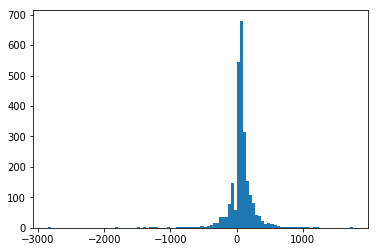

In [96]:
diff1=seq-xgb
diff1_=diff1[(diff1**2)>900]
import matplotlib.pyplot as plt
plt.hist(diff1_,bins=100)
plt.show()

#### Compare with gamma-gamma model

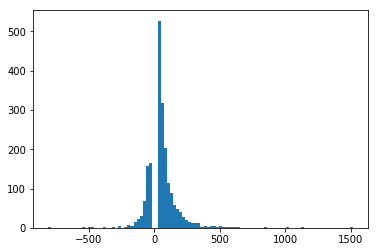

In [93]:
diff2=seq-bys
diff2_=diff2[(diff2**2)>900]
import matplotlib.pyplot as plt
plt.hist(diff2_,bins=100)
plt.show()